In [15]:
import numpy as np
import keyboard
from matplotlib import colormaps as cmaps
import condynsate
from condynsate.utils import format_RGB

In [16]:
# Create an instance of the simulator with visualization
sim = condynsate.Simulator(visualization=True,
                           animation=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


In [17]:
# Load the ground
ground_obj = sim.load_urdf(urdf_path='./cmg_vis/plane.urdf',
                           tex_path='./cmg_vis/check.png',
                           position=[0., 0., -3.],
                           fixed=True,
                           update_vis=False)

# Load a wall for the CMG to attach to
wall_obj = sim.load_urdf(urdf_path='./cmg_vis/plane.urdf',
                         tex_path='./cmg_vis/concrete.png',
                         roll=0.5*np.pi,
                         yaw=np.pi,
                         fixed=True,
                         update_vis=False)

In [18]:
# Load the CMG
cmg_obj = sim.load_urdf(urdf_path='./cmg_vis/cmg.urdf',
                        position=[0., 1.1, 0.],
                        pitch=-0.5*np.pi,
                        fixed=True,
                        update_vis=True)

# Set the mass of the pendulum of the CMG
sim.set_link_mass(urdf_obj=cmg_obj,
                  link_name="mass",
                  mass=1.0)

# Set wheel velocity
sim.set_joint_velocity(urdf_obj=cmg_obj,
                       joint_name='inner_to_wheel',
                       velocity = 50.)

# Set joint damping
sim.set_joint_damping(urdf_obj=cmg_obj,
                      joint_name="world_to_outer",
                      damping=0.01)
sim.set_joint_damping(urdf_obj=cmg_obj,
                      joint_name="outer_to_inner",
                      damping=0.01)

In [19]:
# Variables to track applied torque
prev_torque = -1.0
torque = 0.0
max_torque = 0.5
min_torque = -0.5
torque = 0.5*(max_torque + min_torque)
torque_sat = (torque - min_torque) / (max_torque - min_torque)
inner_color = cmaps['coolwarm'](round(255*torque_sat))[0:3]

# Variables to track mass
prev_mass = 0.0
max_mass = 2.0
min_mass = 0.0
mass = 0.5*(max_mass + min_mass)
mass_sat = (mass - min_mass) / (max_mass - min_mass)
mass_color = cmaps['binary'](round(255*mass_sat))[0:3]

# Variables to track wheel velocity
prev_vel = 0.0
max_vel = 100.0
min_vel = 0.0
vel = 0.5 * (max_vel + min_vel)
vel_sat = (vel - min_vel) / (max_vel - min_vel)
vel_color = cmaps['Reds'](round(255*vel_sat))[0:3]

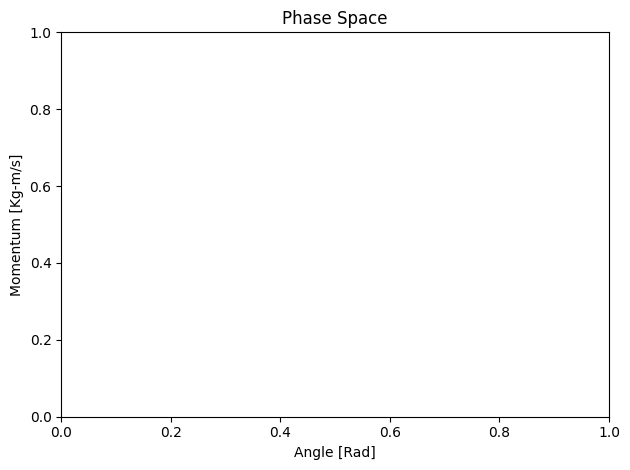

In [20]:
# Open the animator and create a plot for the phase space
plot_ind = sim.add_plot_to_animator(title="Phase Space",
                                    x_label="Angle [Rad]",
                                    y_label="Momentum [Kg-m/s]",
                                    color="r",
                                    tail=None,
                                    x_lim=None,
                                    y_lim=None)
%matplotlib inline
sim.open_animator()
angles = []
times = []

In [21]:
# Wait for user input
while not keyboard.is_pressed("enter"):
    pass

# Run the simulation
done = False
while(not done):
    
    # Collect keyboard IO data for torque
    if keyboard.is_pressed("shift+d"):
        torque = max_torque
    elif keyboard.is_pressed("d"):
        torque = max_torque / 4.0
    elif keyboard.is_pressed("shift+a"):
        torque = min_torque
    elif keyboard.is_pressed("a"):
        torque = min_torque / 4.0
    else:
        torque = 0.0

    # Set the torque and link color based on keyboard inputs
    torque = round(torque,2)
    torque_sat = (torque - min_torque) / (max_torque - min_torque)
    torque_color = cmaps['coolwarm'](round(255*torque_sat))[0:3]
    torque_color = format_RGB(torque_color,
                              range_to_255=True)
    sim.set_joint_torque(urdf_obj=cmg_obj,
                         joint_name="outer_to_inner",
                         torque=torque)
    sim.set_link_color(urdf_obj=cmg_obj,
                       link_name='inner',
                       color=torque_color)

    # Collect keyboard IO data for mass
    if keyboard.is_pressed('e'):
        mass = mass + 0.005*(max_mass - min_mass)
        if mass > max_mass:
            mass = max_mass
    elif keyboard.is_pressed('q'):
        mass = mass - 0.005*(max_mass - min_mass)
        if mass < min_mass:
            mass = min_mass

    # Set the mass and link color based on keyboard inputs
    mass = round(mass,2)
    mass_sat = (mass - min_mass) / (max_mass - min_mass)
    mass_color = cmaps['binary'](round(255*mass_sat))[0:3]
    mass_color = format_RGB(mass_color,
                            range_to_255=True)
    sim.set_link_mass(urdf_obj=cmg_obj,
                      link_name='mass',
                      mass = mass)
    sim.set_link_color(urdf_obj=cmg_obj,
                       link_name='mass',
                       color=mass_color)

    # Collect keyboard IO data for wheel vel
    if keyboard.is_pressed('w'):
        vel = vel + 0.005*(max_vel - min_vel)
        if vel > max_vel:
            vel = max_vel
    elif keyboard.is_pressed('s'):
        vel = vel - 0.005*(max_vel - min_vel)
        if vel < min_vel:
            vel = min_vel

    # Set the wheel vel and link color based on keyboard inputs
    vel = round(vel,2)
    vel_sat = (vel - min_vel) / (max_vel - min_vel)
    vel_color = cmaps['Reds'](round(255*vel_sat))[0:3]
    vel_color = format_RGB(vel_color,
                           range_to_255=True)

    sim.set_joint_velocity(urdf_obj=cmg_obj,
                          joint_name="inner_to_wheel",
                          velocity=vel)
    sim.set_link_color(urdf_obj=cmg_obj,
                       link_name='wheel',
                       color=vel_color)
    
    # Set the plot data
    times.append(sim.time)
    angle, velocity = sim.get_joint_state(cmg_obj, "world_to_outer")
    angles.append(angle)
    sim.set_plot_data(plot_ind, times, angles)

    # Step the sim
    sim.step(real_time=True,
             update_vis=True,
             update_ani=True)
    
    # Collect keyboard IO for termination
    if keyboard.is_pressed("esc"):
        done = True